# Plotting result data,importing Mnist data,plotting random examples

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
    x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test)

def plot_random_examples(x, y, p=None):
    indices = np.random.choice(range(0, x.shape[0]), 10)
    y = np.argmax(y, axis=1)
    if p is None:
        p = y
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[index].reshape((28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]), color=col)
    return plt

def plot_results(history):
    plt.figure(figsize=(12, 4))
    epochs = len(history['val_loss'])
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['val_loss'], label='Val Loss')
    plt.plot(range(epochs), history['train_loss'], label='Train Loss')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history['val_acc'], label='Val Acc')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt


# Neural Network from Scratch in TensorFlow

## Task 1:Introduction and Importing LIbraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('TensorFlow Version',tf.__version__)

TensorFlow Version 2.2.0


## Task 2:Initializing Neural Network

In [ ]:
#creating a neural network class
#This clas will take list with values like:
#net=NeuralNetwork([10.100,10])10-features,10 classses,100 units in hidden layer

class NeuralNetwork:
    def __init__(self,layers):
        self.layers = layers
        self.L =len(layers) #no. of layers
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {}#weights for different layers
        self.b = {}#bias for different layers
        
        self.dW = {}#gradient for weights for different layers
        self.db = {}#gradient for bias for different layers
        
        #After initialization call the setup function
        self.setup()
    
    def setup(self):
        #Here we setup the model i.e.,we initialize value for parameter and W and b for various layers
        for i in range(1,self.L):#starting with index 1 as 0th index or 1st layer is the input layer
            self.W[i]=tf.Variable(tf.random.normal(shape=(self.layers[i],self.layers[i-1])))#we can also use random.unifrom
            self.b[i]=tf.Variable(tf.random.normal(shape=(self.layers[i],1)))
            '''You have Neural Network with 1 hidden layer. This hidden layer has 10 nodes. The output layer has 3 nodes. The layers are densely connected. What would be the shape of parameter b (bias) for the output layer?
                (3, 1)
            '''

## Task 3:Forward Pass

In [ ]:
class NeuralNetwork(NeuralNetwork):#extending the above NeuralNetwork class
    def forward_pass(self, A):
        A = tf.convert_to_tensor(A, dtype=tf.float32)
        for i in range(1, self.L):
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i])#finding linear sum W^tX+b for first hidden layers onwards.
            if i != self.L-1:
                A = tf.nn.relu(Z)
            else:
                A = Z
        return A

## Task 4:Computing Loss and Updating Parameters

In [ ]:
class NeuralNetwork(NeuralNetwork):
  def compute_loss(self,A,Y):
    #computes loss for each layers
    loss = tf.nn.softmax_cross_entropy_with_logits(Y,A)
    return tf.reduce_mean(loss)
  '''In order to calculate the loss with the tf.nn.softmax_cross_entropy_with_logits function, we must pass the true labels and the softmax activation output from the output layer. 
      False
  '''
  def update_params(self,lr):
    #lr=learning rate
    for i in range(1,self.L):
      self.W[i].assign_sub(lr * self.dW[i])#w=w-lr*dW
      self.b[i].assign_sub(lr * self.db[i])#b=b-lr*db

## Task 5:Predict and Info functions

In [ ]:
class NeuralNetwork(NeuralNetwork):
    def predict(self, X):
        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A), axis=1)#aixs=1 to tell we are looking for columns
    
    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)

## Task 6:Training on Batch

In [ ]:
class NeuralNetwork(NeuralNetwork):
    def train_on_batch(self, X, Y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
          #persistent=True as we want to use the tape for all the parameters
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for key in self.W.keys():
            self.dW[key] = tape.gradient(loss, self.W[key])
            self.db[key] = tape.gradient(loss, self.b[key])
        del tape
        self.update_params(lr)
        
        return loss.numpy()

## Task 7:Training on Complete Test

In [ ]:
class NeuralNetwork(NeuralNetwork):
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history = {
            'val_loss': [],
            'train_loss': [],
            'val_acc': []
        }
        
        for e in range(0, epochs):
            epoch_train_loss = 0.
            print('Epoch {}'.format(e), end='.')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')
                    
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            
            val_A = self.forward_pass(x_test)
            history['val_loss'].append(self.compute_loss(val_A, y_test).numpy())
            
            val_preds = self.predict(x_test)
            history['val_acc'].append(np.mean(np.argmax(y_test, axis=1) == val_preds.numpy()))
            print('Val Acc:', history['val_acc'][-1])
        return history

## Task 8:Application

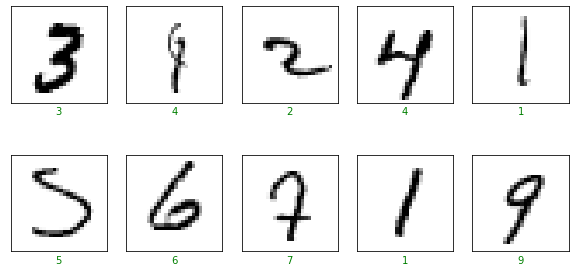

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()
plot_random_examples(x_train, y_train).show()

In [ ]:
net = NeuralNetwork([784, 128, 128, 10])
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 128
Layer 2, Units 128
--------------
Number of parameters: 118282


In [ ]:
batch_size = 120
epochs = 5
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3

print('Steps per epoch:', steps_per_epoch)

Steps per epoch: 500


In [ ]:
history = net.train(
    x_train, y_train,
    x_test, y_test,
    epochs, steps_per_epoch,
    batch_size, lr
)

Epoch 0...........Val Acc: 0.8017
Epoch 1...........Val Acc: 0.831
Epoch 2...........Val Acc: 0.8463
Epoch 3...........Val Acc: 0.8552
Epoch 4...........Val Acc: 0.8625


## Task 9:Results

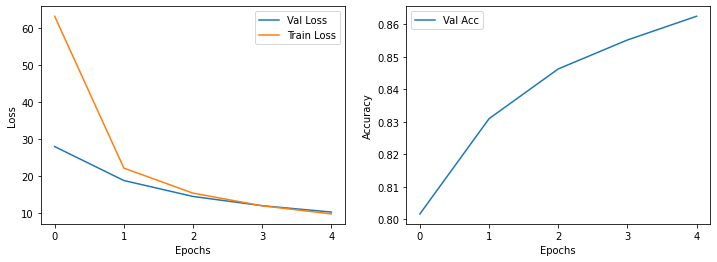

In [ ]:
plot_results(history).show()

In [ ]:
preds = net.predict(x_test)

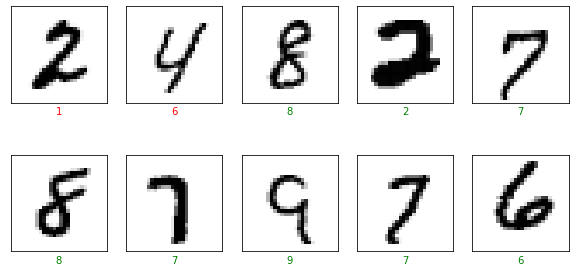

In [ ]:
plot_random_examples(x_test, y_test, preds.numpy()).show()